In [1]:
import numpy as np
import hmvec as hm
import matplotlib
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15
cosmo = Planck15

In [13]:
#Plot settings
%matplotlib inline
#matplotlib.rcParams['axes.labelsize'] = 'xx-large'
#matplotlib.rcParams['xtick.labelsize'] = 'x-large'
#matplotlib.rcParams['ytick.labelsize'] = 'x-large'
#matplotlib.rcParams['legend.fontsize'] = 'x-large'
matplotlib.rcParams['axes.titlesize'] = 'xx-large'

# Model

In [5]:
#Grid for Integration
Nz = 210                                 # num of redshifts
Nm = 91                                 # num of masses
Nk = 1000                                # num of wavenumbers
redshifts = np.linspace(0.012, 10.22, Nz)             # redshifts
logmass = np.arange(6,15.005,0.1)
masses = 10**logmass           # masses
ells = np.linspace(150., 2000., 20)
ks = np.array([])
chis = cosmo.comoving_distance(redshifts).value
for ell in ells:
    ks = np.append(ks, ell/chis) 
ks = np.sort(ks)
freq = np.array([[271.0]])

#Initialize Halo Model
hcos = hm.HaloModel(redshifts, ks, ms=masses)

#Set CIB Parameters
hcos.set_cibParams('planck')

# CIB x CIB

### 3D Power Spectrum

First, let's get our 3D power spectrum.

In [6]:
#Get Power Spectra
hcos.get_power_2halo('cib', nu_obs=[[545]])

> /global/u1/y/yogesh3/git/hmvec/hmvec/hmvec.py(767)_2haloint()
-> integral = np.trapz(integrand,ms,axis=-2)


(Pdb)  int = np.transpose(integrand[:,:,5])
(Pdb)  int.shape()


*** TypeError: 'tuple' object is not callable


(Pdb)  int.shape


(91, 210)


(Pdb)  q


BdbQuit: 

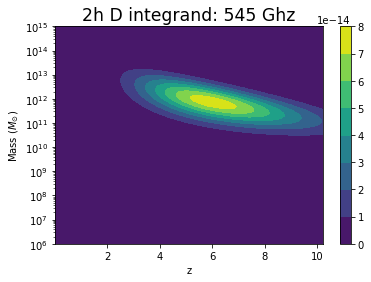

In [14]:
integrand = np.load('integrand.npy')

plt.contourf(redshifts, masses, integrand)
plt.title('2h D integrand: 545 Ghz')
plt.yscale('log')
plt.colorbar()
plt.xlabel('z')
plt.ylabel(r'Mass ($M_{\odot}$)')

ax = plt.gca()

#Y axis Ticks
majloc = plt.LogLocator(numticks=10)
ax.yaxis.set_major_locator(majloc)
minorticks = np.arange(0.1, 1, 0.1)
minloc = plt.LogLocator(subs=minorticks, numticks=10)
ax.yaxis.set_minor_locator(minloc)

print(ax.yaxis.get_minor_locator())
print(ax.yaxis.get_minor_formatter())
print(ax.xaxis.get_minor_locator())
print(ax.xaxis.get_minor_formatter())

plt.savefig('hmvec_int.pdf', dpi=600, bbox_inches='tight')

Now let's plot it. We expect it to peak at around k = 0.02

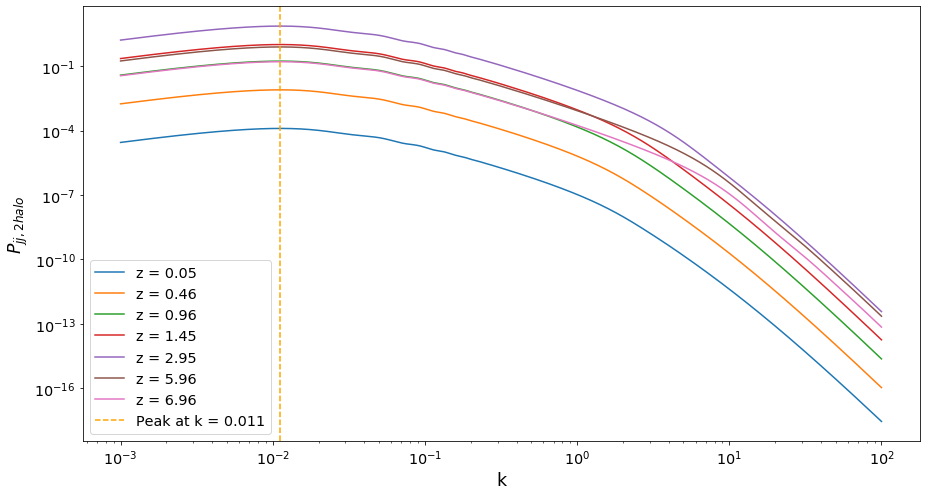

In [11]:
#Which zs to look at
test_zs = np.array([0.1, 0.5, 1, 1.5, 3, 6, 7])

#Plot Power Spectra
plt.figure(figsize=(15,8))
for z in test_zs:
    #Get index
    zi = np.where(abs(z - redshifts) <= 0.05)[0][0]
    
    #Spectra
    plt.loglog(ks, Pjj_2h[zi,:], label=f"z = {redshifts[zi]:0.2f}")

#Plot Peak
kpeak = ks[np.argmax(Pjj_2h[0,:])]
plt.axvline(x = kpeak, ls='--', color='orange', label=f'Peak at k = {kpeak:0.3f}')

#Gravy
plt.legend()
plt.ylabel(r"$P_{jj, 2halo}$")
plt.xlabel('k')
plt.savefig('Pjj.png', dpi=500, bbox_inches='tight');

In [ ]:
#Plot the u(z,k)
plt.figure(figsize=(15,8))
for z in test_zs:
    plt.loglog(ks, hcos.u[z,])

### 2D Power Spectrum

Now let's integrate along the redshift to get the 2D power spectrum.

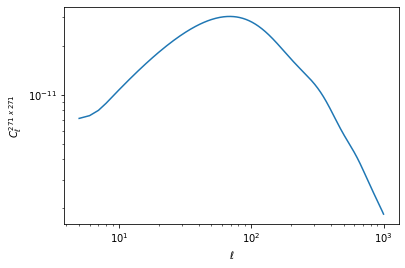

In [10]:
#Limber Integrals
Nl = 1000
ells = np.linspace(5, 1000, Nl)
Cii, Cii_integrand = hcos.C_ii(ells, redshifts, ks, Pjj_2h, dcdzflag=True)

#Plot Cii
plt.loglog(ells, Cii)
plt.xlabel(r'$\ell$')
plt.ylabel(rf'$C^{{ {freq[0,0]:0.0f} \;x\; {freq[0,0]:0.0f} }}_\ell$');
plt.savefig('Cii_2h.png', dpi=900, bbox_inches='tight')

## $\frac{dC_{II}}{dz} (z, \ell)$

There are still some wiggles at around $\ell \sim 2\times10^2 - 6 \times 10^2$, which should be smoothed out, so let's plot the integrand of the limber integral to see what's up.

In [ ]:
#Which ells to look at
test_ells = np.array([2.0e2, 3.0e2, 4.0e2, 5.0e2, 6.0e2])

#Plot
plt.figure(figsize=(10,7))
for ell in test_ells:
    #Get index
    i = np.where(abs(ell - ells) <= 1)[0][0]

    #Spectra
    plt.semilogy(redshifts, Cii_integrand[:, i], label=rf"$\ell = {ells[i]:0.0f}$")

    #Gravy
    plt.xlabel(r'$z$')
    plt.title(r'$\frac{dC_{II}}{dz}$', fontsize=24)
    plt.legend()
plt.savefig('dCdz_ii_l.png', dpi=500, bbox_inches='tight');

# Lensing x Lensing

## $\frac{dC_{\kappa \kappa}}{dz} (z, \ell)$

First, let's add to the model.

In [ ]:
#Add to the model
zsource = 1.0 # delta-function source population
ngal = 1e-4 # number density of lenses per mpc3 (to solve for stellar mass threshold in HOD)
hcos.add_hod("g",ngal=ngal+redshifts*0.,corr="max")
hcos.add_battaglia_profile("electron",family="AGN",xmax=50,nxs=30000)

Now we can actually calculate all of the power spectra.

In [ ]:
#Power Spectra
Pnn = hcos.get_power("nfw",verbose=False)
Pne = hcos.get_power("nfw","electron",verbose=False )
Pee = hcos.get_power("electron","electron",verbose=False )
Pmm = hcos.total_matter_power_spectrum(Pnn,Pne,Pee)

#Limber Integrals
Ckk0, Ckk0_integrand = hcos.C_kk(ells,redshifts,ks,Pnn,lzs1=zsource,lzs2=zsource, dcdzflag=True)
Ckk, Ckk_integrand = hcos.C_kk(ells,redshifts,ks,Pmm,lzs1=zsource,lzs2=zsource, dcdzflag=True)

And finally, plot the integrand of the limber integral.

The first is $C/C_0$.

In [ ]:
plt.figure(figsize=(10,7))

for ell in test_ells:
    #Get index
    i = np.where(abs(ell - ells) <= 1)[0][0]

    #Plot
    plt.semilogy(redshifts, Ckk_integrand[:, i]/Ckk0_integrand[:, i], label=rf"$\ell = {ells[i]:0.0f}$")

    #Gravy
    plt.xlabel(r'$z$')
    plt.title(r'$\frac{dC^{\kappa \kappa}}{dC^{\kappa \kappa}_0}$', fontsize=24)
    plt.legend()

plt.savefig('dCdz_kk_0.png', dpi=500, bbox_inches='tight');

In [ ]:
#Plot
plt.figure(figsize=(10,7))

for ell in test_ells:
    #Get index
    i = np.where(abs(ell - ells) <= 1)[0][0]

    #Plot
    plt.semilogy(redshifts, Ckk_integrand[:, i], label=rf"$\ell = {ells[i]:0.0f}$")

    #Gravy
    plt.xlabel(r'$z$')
    plt.title(r'$\frac{dC^{\kappa \kappa}}{dz}$', fontsize=24)
    plt.legend()
    
plt.savefig('dCdz_kk.png', dpi=500, bbox_inches='tight');

### 2D Power Spectrum

Let's now manually integrate the integrand w.r.t. redshift to see if we get back our 2D power spectrum.

In [ ]:
#Integrate
Ckk_man = np.trapz(Ckk_integrand, redshifts, axis=0)
Ckk0_man = np.trapz(Ckk0_integrand, redshifts, axis=0)

#Plot
plt.figure(figsize = (7,5))
plt.plot(ells, Ckk_man/Ckk0_man, color='red', label='Manually integrated')
plt.plot(ells, Ckk/Ckk0, ls='--', label='From hmvec')
plt.ylabel(r"$C^{kk}/C^{kk}_{0}$")
plt.xlabel(r"$\ell$")
plt.legend()

plt.savefig('Ckk_compare.png', dpi=500, bbox_inches='tight');

We see that we are indeed looking at the correct integrand.